#### Preprocessing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import rasterio
import rioxarray
import xarray as xr
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score

In [3]:
from collections import Counter
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white



def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."
    

def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
        try:
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image


In [4]:
img_path = "/home/akansh-i2sc/Desktop/Study/detect-car-LR/data/bauhaus/**/*.tif"
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

Initial size of dataset 833
Most common size of the dataset (4, 158, 169)
Final size of dataset(after removing faulty size images) 819
Final size of dataset(after removing faulty black pixels in images) 713
Final size of dataset(after removing faulty white pixels in images) 635


(-0.5, 168.5, 157.5, -0.5)

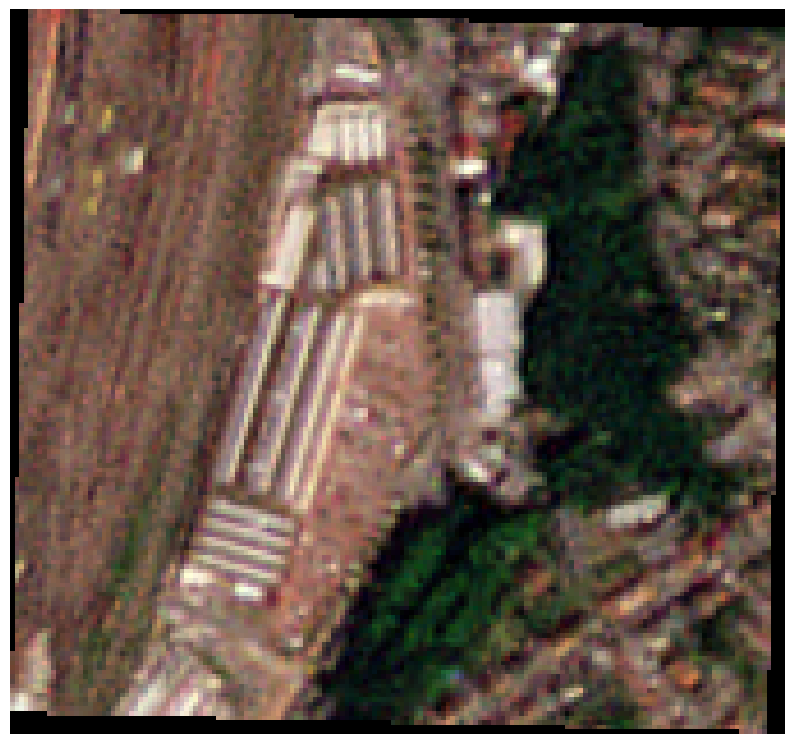

In [5]:
plt.figure(figsize=(10,10))
img = rioxarray.open_rasterio(clean_3[0])
plt.imshow(img.data[0:3].transpose(1, 2, 0))
plt.axis('off')

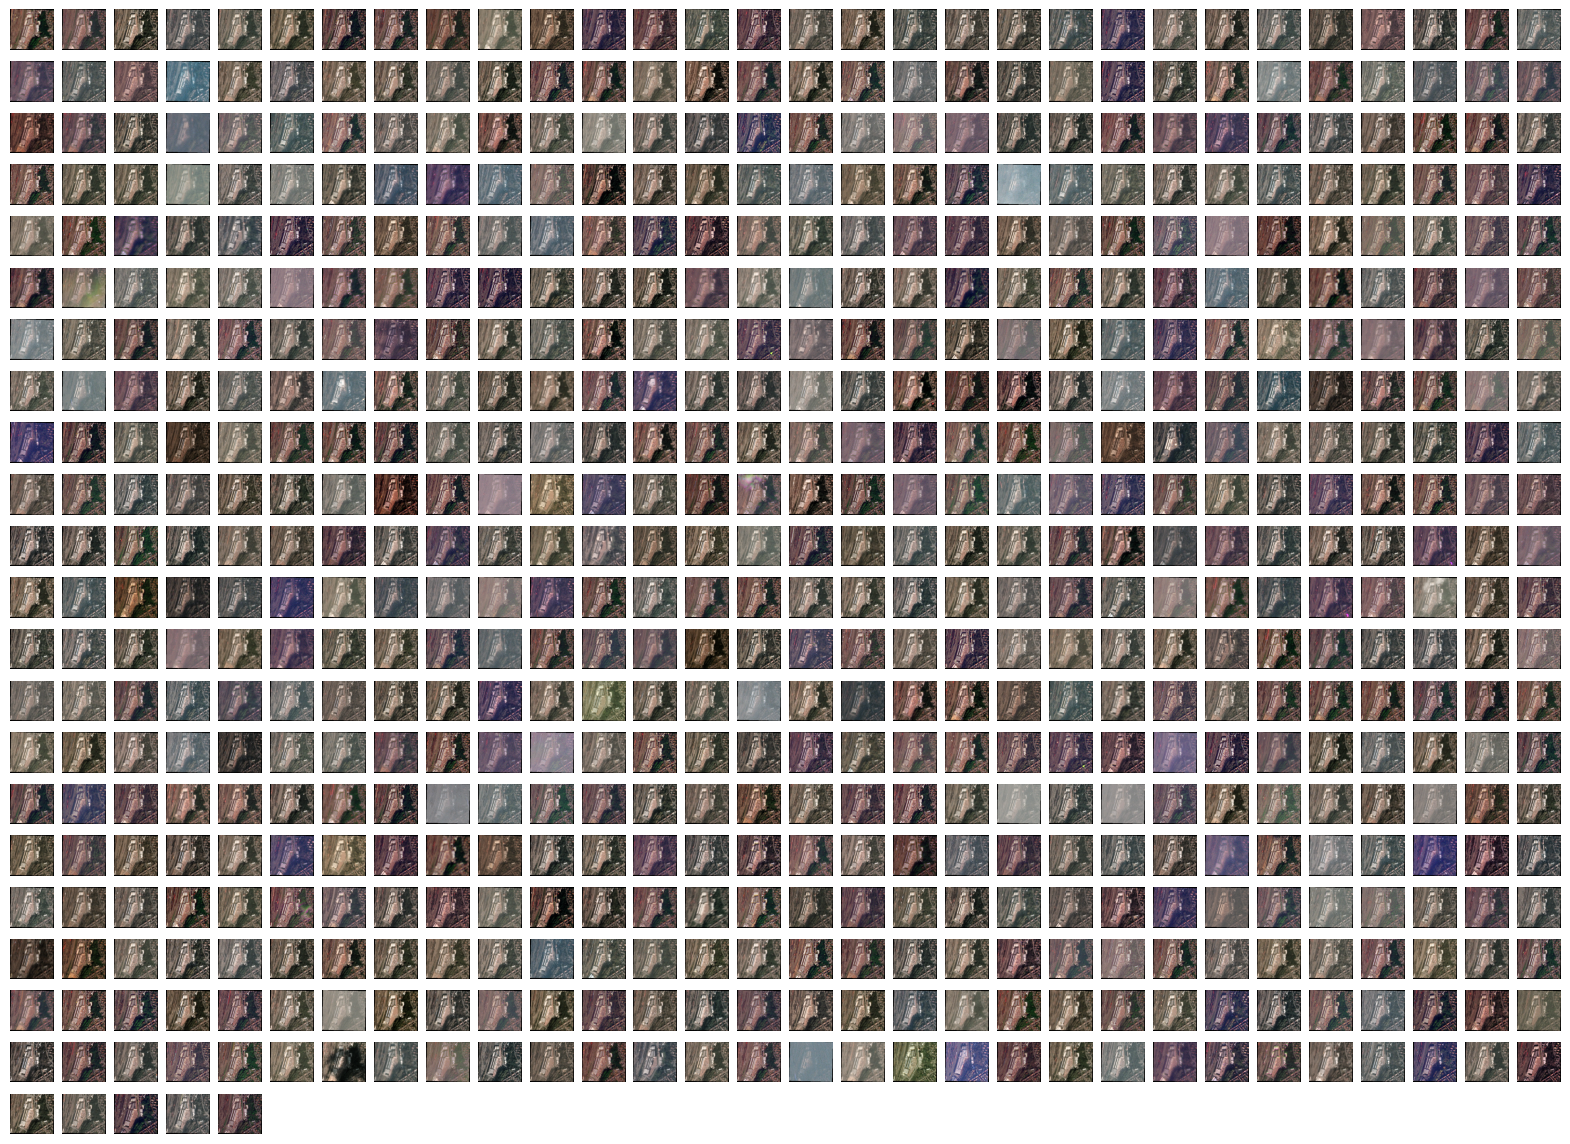

In [6]:
plt.figure(figsize=(20,20))
for i in range(len(clean_3)):
    plt.subplot(30,30,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')

In [7]:
img.shape

(4, 158, 169)

In [8]:
from torch import nn, Tensor
import torch
from torch.nn import functional as F
from typing import List, Any, Dict, Tuple
from abc import abstractmethod
from typing import Any

In [9]:
class BaseModel(nn.Module):
    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def loss_function(self, batch: Tensor, *inputs: Any, **kwargs) -> Tensor:
        raise NotImplementedError

class BaseAE(BaseModel):
    def __init__(self, visualisation_channels):
        super().__init__()

        self.visualisation_channels = visualisation_channels

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        z = self.encode(torch.nan_to_num(input))
        return self.decode(z)

    def loss_function(self,
                      input: Tensor,
                      results: Dict,
                      mask_invalid: bool = False,
                      **kwargs) -> Dict:

        if not mask_invalid:
            recons_loss = F.mse_loss(results, torch.nan_to_num(input))
        else:
            invalid_mask = torch.isnan(input)
            recons_loss = \
                F.mse_loss(results[~invalid_mask], input[~invalid_mask])

        return {'loss': recons_loss, 'Reconstruction_Loss': recons_loss}

    def _visualise_step(self, batch):
        result = self.forward(batch)
        rec_error = (batch - result).abs()

        return batch[:, self.visualisation_channels], \
            result[:, self.visualisation_channels], \
            rec_error.max(1)[0]

    @property
    def _visualisation_labels(self):
        return ["Input", "Reconstruction", "Rec error"]

class BaseVAE(BaseAE):
    def sample(self, batch_size: int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

class SimpleAE(BaseAE):
    def __init__(self,
                 input_shape: Tuple[int],
                 visualisation_channels):
        super().__init__(visualisation_channels)

        channels = input_shape[0]

        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 7),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 7),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1,
                               output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, channels, 3, stride=2, padding=1,
                               output_padding=1),
        )

    def encode(self, input: Tensor) -> Tensor:
        return self.encoder(input)

    def decode(self, input: Tensor) -> Tensor:
        result = self.decoder(input)
        return result


class SimpleVAE(BaseVAE):

    def __init__(self,
                 input_shape: Tuple[int],
                 latent_dim: int,
                 visualisation_channels,
                 **kwargs) -> None:
        super().__init__(visualisation_channels)

        self.latent_dim = latent_dim

        in_channels = input_shape[0]
        out_channels = input_shape[0]

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 7),
            nn.LeakyReLU()
        )

        self.width = (input_shape[1] // 2) // 2 - 6

        self.fc_mu = nn.Linear(256 * self.width * self.width, latent_dim)
        self.fc_var = nn.Linear(256 * self.width * self.width, latent_dim)

        self.decoder_input = \
            nn.Linear(latent_dim, 256 * self.width * self.width)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 7),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1,
                               output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, out_channels, 3, stride=2, padding=1,
                               output_padding=1),
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, self.width, self.width)
        result = self.decoder(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: Mean of the latent Gaussian [B x D]
        :param logvar: Standard deviation of the latent Gaussian [B x D]
        :return: [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(torch.nan_to_num(input))
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), mu, log_var]

    def loss_function(self, input: Tensor, results: Any, **kwargs) -> Dict:
        """
        Computes the VAE loss function.

        :param args:
        :param kwargs:
        :return:
        """
        # invalid_mask = torch.isnan(input)
        input = torch.nan_to_num(input)

        recons = results[0]
        mu = results[1]
        log_var = results[2]

        # Account for the minibatch samples from the dataset
        kld_weight = kwargs['M_N']

        recons_loss = F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss,
                'Reconstruction_Loss': recons_loss,
                'KLD': -kld_loss}

    def sample(self,
               num_samples: int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [19]:
df = label_csv(clean_3)
df.head()

Class distribution in dataset: 0    553
1     82
Name: label, dtype: int64


,image_path,day,label
0,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Tuesday,0
1,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Sunday,1
2,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Thursday,0
3,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Saturday,0
4,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Tuesday,0


In [20]:
median_image, _ = create_median_image(glob.glob(img_path, recursive=True))

In [21]:
### Pytorch custom dataset class
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class VAE_dataset(Dataset):
    def __init__(self, df, median_img, transform=None):
        self.df = df
        self.median_img = median_img
        self.transform = transform
        self.median_img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]) #Experiment with adding noise here
        ])

    def __getitem__(self, idx):
        img_path = self.df.image_path.values[idx]
        img_1 = rioxarray.open_rasterio(img_path)
        img_1 = img_1.data[0:3].transpose(1, 2, 0)
        label = self.df.label.values[idx]
        img_2 = self.median_img_transform(self.median_img)

        if self.transform:
            img_1 = self.transform(img_1)
            # img_2 = self.transform(img_2) #median image augmentation, need experiments here. 
        return img_1, img_2, label

    def __len__(self):
        return len(self.df)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from tqdm.auto import tqdm
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#train test split
train, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

cuda:0
Train size: (571, 3)
Test size: (64, 3)
Train class distribution: 0    497
1     74
Name: label, dtype: int64
Test class distribution: 0    56
1     8
Name: label, dtype: int64


In [23]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    # transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])


train_dataset = VAE_dataset(train,median_image, transform=train_transform)
test_dataset = VAE_dataset(test, median_image, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
for x1,x2,y in train_loader:
    print(x1.shape)
    print(x2.shape)
    print(y.shape)
    break

torch.Size([32, 3, 158, 169])
torch.Size([32, 3, 158, 169])
torch.Size([32])


In [25]:
model

SimpleVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (fc_mu): Linear(in_features=278784, out_features=1024, bias=True)
  (fc_var): Linear(in_features=278784, out_features=1024, bias=True)
  (decoder_input): Linear(in_features=1024, out_features=278784, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [26]:
input_shape = (3, 158, 169)
visualisation_channels = [0, 1, 2]
latent_dim = 1024
model = SimpleVAE(input_shape, latent_dim, visualisation_channels)
print("Created model")

Created model


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [28]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [30]:
criterion = loss_function
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (x1,x2,y) in enumerate(train_loader):
        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)
        # ===================forward=====================
        output = model(x1)
        loss = criterion(output, x1)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        if batch_idx % 50 == 0:
            print(f'epoch {epoch} batch {batch_idx} loss {loss.item():.4f}')


In [36]:
for x,y,x in (train_loader):
    break

In [38]:
model.eval()
model(x1.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x322048 and 278784x1024)

In [40]:
x1.shape

torch.Size([32, 3, 158, 169])